In [2]:
import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
import json

import numpy as np

## New laplacian code

In [3]:
def create_3d_laplacian_matrix(n):
    total_points = n * n * n  # Total number of grid points
    
    laplacian = lil_matrix((total_points, total_points))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                row = i * n * n + j * n + k  # Current grid point
                
                # Diagonal element
                laplacian[row, row] = 6
                
                # Check and update neighbors (left, right, up, down, front, back)
                if i > 0:
                    laplacian[row, ((i - 1) * n + j) * n + k] = -1  # Left
                if i < n - 1:
                    laplacian[row, ((i + 1) * n + j) * n + k] = -1  # Right
                if j > 0:
                    laplacian[row, (i * n + (j - 1)) * n + k] = -1  # Down
                if j < n - 1:
                    laplacian[row, (i * n + (j + 1)) * n + k] = -1  # Up
                if k > 0:
                    laplacian[row, (i * n + j) * n + (k - 1)] = -1  # Back
                if k < n - 1:
                    laplacian[row, (i * n + j) * n + (k + 1)] = -1  # Front
    
    # Convert to CSR format for efficient arithmetic operations
    laplacian = laplacian.tocsr()
    laplacian = -laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(laplacian.shape[0]):
        start = laplacian.indptr[row]
        end = laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(laplacian.indices[start:end])
        values.extend(laplacian.data[start:end])

    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n*n,n*n*n))
    )

    return coo_matrix


# Example usage
grid_size = 4  # Change this value to adjust the grid size
laplacian_matrix = create_3d_laplacian_matrix(grid_size)

print(laplacian_matrix.to_dense())  # Print the dense representation for visualization

tensor([[-6.,  1.,  0.,  ...,  0.,  0.,  0.],
        [ 1., -6.,  1.,  ...,  0.,  0.,  0.],
        [ 0.,  1., -6.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., -6.,  1.,  0.],
        [ 0.,  0.,  0.,  ...,  1., -6.,  1.],
        [ 0.,  0.,  0.,  ...,  0.,  1., -6.]])


## Rewrite the original code using torch

In [33]:

# Simulating the TDGL equation
a, b, k = -1.0, 1.0, 100.0 #configuração: (a<0, b>0) ou (a>0, b>0)
dh, dt = 1.0, 1e-3
Ng, Tf = 16, 10001
device = 'cpu'
a = torch.tensor(a, device=device)
b = torch.tensor(b, device=device)
k = torch.tensor(k, device=device)
dh = torch.tensor(dh, device=device)
dt = torch.tensor(dt, device=device)
Ng = torch.tensor(Ng, device=device)
Tf = torch.tensor(Tf, device=device)
T = torch.tensor([0.1], device=device)

# Ng, Tf = 64, 10001
master_list = []


def laplacian(n):
    total_points = n * n * n  # Total number of grid points
    
    laplacian = lil_matrix((total_points, total_points))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                row = i * n * n + j * n + k  # Current grid point
                
                # Diagonal element
                laplacian[row, row] = 6
                
                # Check and update neighbors (left, right, up, down, front, back)
                if i > 0:
                    laplacian[row, ((i - 1) * n + j) * n + k] = -1  # Left
                if i < n - 1:
                    laplacian[row, ((i + 1) * n + j) * n + k] = -1  # Right
                if j > 0:
                    laplacian[row, (i * n + (j - 1)) * n + k] = -1  # Down
                if j < n - 1:
                    laplacian[row, (i * n + (j + 1)) * n + k] = -1  # Up
                if k > 0:
                    laplacian[row, (i * n + j) * n + (k - 1)] = -1  # Back
                if k < n - 1:
                    laplacian[row, (i * n + j) * n + (k + 1)] = -1  # Front
    
    # Convert to CSR format for efficient arithmetic operations
    laplacian = laplacian.tocsr()
    laplacian = -laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(laplacian.shape[0]):
        start = laplacian.indptr[row]
        end = laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(laplacian.indices[start:end])
        values.extend(laplacian.data[start:end])

    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n*n,n*n*n))
    )

    return coo_matrix

def integrate(L, x, y, z, u):
    '''  simulates the equation and plots it at different instants '''

    #f = plt.figure(figsize=(15, 15), dpi=80);

    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng * Ng * Ng, 1), device=device)
        u = u - dt * (a * u + b * u * u * u - k * torch.mm(L, u)) + torch.sqrt(2 * T * dt) * noise  # Euler's method

        # if (i==0):      configPlot(x, y, u, f, 1, i);
        # if (i==1):      configPlot(x, y, u, f, 2, i);
        # if (i==10):     configPlot(x, y, u, f, 3, i);
        # if (i==100):    configPlot(x, y, u, f, 4, i);
        # if (i==1000):   configPlot(x, y, u, f, 5, i);
        if (i==10000):
            master_list.append(u)
            #configPlot(x, y, u, f, 6, i)


def configPlot(x, y, z, u,f, n_, i):
    u = u.view((Ng, Ng, Ng))
    u = u.cpu()
    U = u.numpy()
    sp =  f.add_subplot(3, 3, n_ )
    plt.setp(sp.get_yticklabels(), visible=False)
    plt.setp(sp.get_xticklabels(), visible=False)
    plt.pcolormesh(x,y,z,U, cmap=plt.cm.RdBu);
    plt.title('Time=%d'%i)


In [34]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cpu')

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
z = torch.linspace(-1, 1, Ng)
X, Y, Z = torch.meshgrid(x, y, z)

## simula 100 configurações finais com os parametros iniciais

#L = L.to_dense()
L = laplacian(Ng)
L = L.to(device)         # construct the laplacian
for i in range(2):
  u = torch.randn(Ng * Ng * Ng, 1, device=device)  # Initial data
  integrate(L, x, y, z, u)    # simulate
  print(f'Time = {i+1}/2')


## salva estas configurações em um arquivo JSON

# mlist = [[] for _ in range(101)]
# num = 0
# for l in master_list:
#     l = l.cpu()
#     for i in range(len(l)):
#         mlist[num].append(l[i].item())
#     num+=1

# file_path = 'data_configs_a_pos_b_pos.json'

# with open(file_path, 'w') as json_file:
#    json.dump(mlist, json_file)

Time = 1/2
Time = 2/2


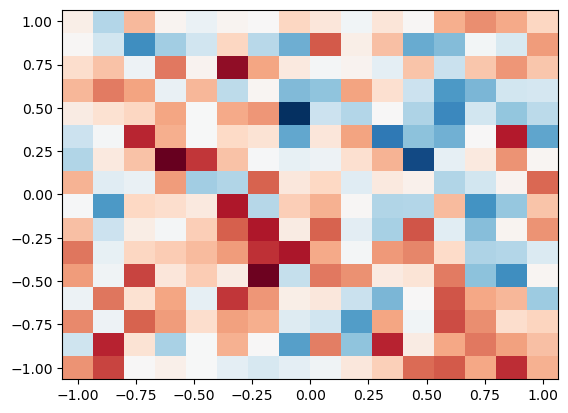

In [35]:
x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
z = torch.linspace(-1, 1, Ng)
X, Y, Z = torch.meshgrid(x, y, z)

u = master_list[0].view(Ng,Ng,Ng)
U = u.cpu().numpy()

plt.pcolormesh(x,y,U[3], cmap=plt.cm.RdBu)

In [38]:
import numpy as np
import plotly.graph_objs as go

# Create a 4x4x4 random matrix for demonstration purposes
matrix = np.random.rand(Ng, Ng, Ng)

# Define a colormap (e.g., "viridis") to map values to colors
cmap = 'thermal'

# Create a 3D scatter plot
x, y, z = np.meshgrid(np.arange(Ng), np.arange(Ng), np.arange(Ng))
## flatten the 4x4x4 matrix for mapping colors
values = U.flatten()
colors = np.array(values)
hover_text = [f"Value: {val:.2f}" for val in values]

scatter = go.Scatter3d(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    mode='markers',
    marker=dict(
        size=10,
        color=colors,
        colorscale=cmap,
        colorbar=dict(title="Color Mapping"),
    ),
    text=hover_text,
    hoverinfo='text',
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X'),
        yaxis=dict(title='Y'),
        zaxis=dict(title='Z'),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

fig = go.Figure(data=[scatter], layout=layout)

fig.show()


In [39]:
# ## visualizar a configuração final individualmente

# u = master_list[0]
# u = u.view((Ng, Ng, Ng))
# u = u.cpu()
# U = u.numpy()

# plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu)